# Init

In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/miniconda3/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/miniconda3/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
sys.path.insert(0, '../../')


adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

# CFGP-based

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

## Random sampling

### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']


wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Loading dataset: gasdb
### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']
### Loading model: cgcnn
### Loaded CGCNN with 189121 parameters.
cmd:
  checkpoint_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/checkpoints/2020-06-23-19-55-01-cnn
  identifier: cnn
  logs_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/logs/2020-06-23-19-55-01-cnn
  print_every: 100
  results_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/results/2020-06-23-19-55-01-cnn
  seed: null
  timestamp: 2020-06-23-19-55-01-cnn
dataset:
  src: ../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: wandb
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  warmup_epochs: 10
  war

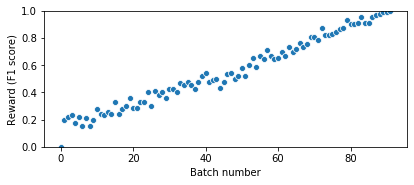

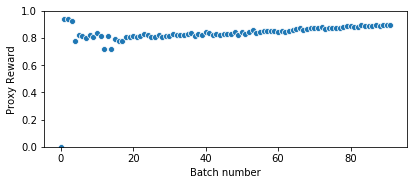

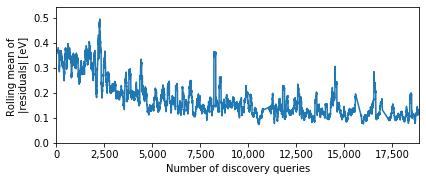

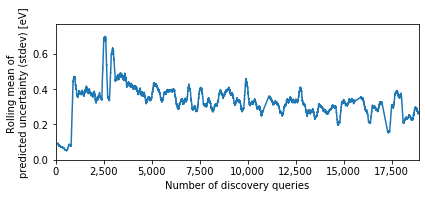

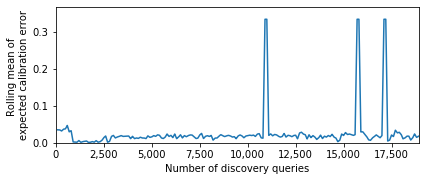

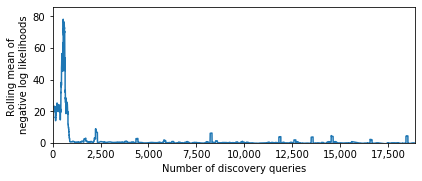

In [4]:
import sys
from src.discoverers.adsorption.randomsearch_cfgp import RandomSearcherCFGP


# Initialize
rs_discoverer = RandomSearcherCFGP(db_dir=db_dir,
                                   target_energy=target_energy,
                                   quantile_cutoff=quantile_cutoff,
                                   batch_size=batch_size,
                                   training_features=training_features,
                                   training_labels=training_labels,
                                   training_surfaces=training_surfaces,
                                   sampling_features=sampling_features,
                                   sampling_labels=sampling_labels,
                                   sampling_surfaces=sampling_surfaces,
                                   init_train=False  # Set to `False` only for warm starts
                                  )

# Load
rs_dir = '../random_cfgp/'
nn_cp = rs_dir + 'checkpoints/2020-06-21-16-17-43-cnn/checkpoint.pt'
gp_cp = rs_dir + 'gp_state.pth'
norm_cp = rs_dir + 'normalizer.pth'
rs_discoverer.load_last_run(nn_cp, gp_cp, norm_cp)

# Plot
rs_figs = rs_discoverer.plot_performance(window=100)

## MMS

### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']


wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Loading dataset: gasdb
### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']
### Loading model: cgcnn
### Loaded CGCNN with 189121 parameters.
cmd:
  checkpoint_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/checkpoints/2020-06-23-19-55-49-cnn
  identifier: cnn
  logs_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/logs/2020-06-23-19-55-49-cnn
  print_every: 100
  results_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/results/2020-06-23-19-55-49-cnn
  seed: null
  timestamp: 2020-06-23-19-55-49-cnn
dataset:
  src: ../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: wandb
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  warmup_epochs: 10
  war

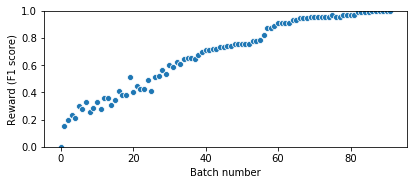

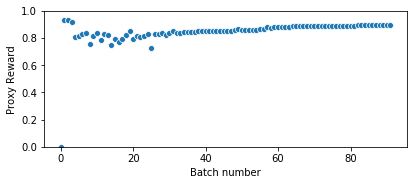

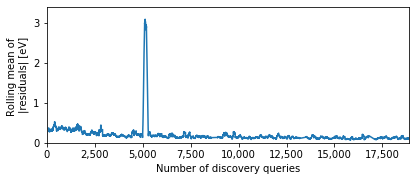

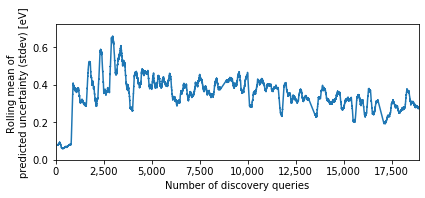

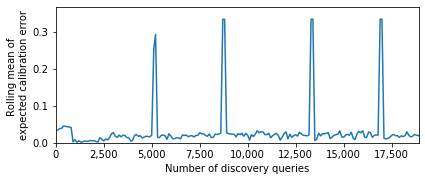

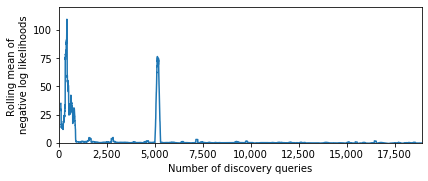

In [5]:
import sys
from src.discoverers.adsorption.mms import MultiscaleDiscoverer


# Initialize
mms_discoverer = MultiscaleDiscoverer(db_dir=db_dir,
                                      target_energy=target_energy,
                                      quantile_cutoff=quantile_cutoff,
                                      batch_size=batch_size,
                                      training_features=training_features,
                                      training_labels=training_labels,
                                      training_surfaces=training_surfaces,
                                      sampling_features=sampling_features,
                                      sampling_labels=sampling_labels,
                                      sampling_surfaces=sampling_surfaces,
                                      init_train=False  # Set to `False` only for warm starts
                                     )

# Load
mms_dir = '../MMS/'
nn_cp = mms_dir + 'checkpoints/2020-06-21-17-21-49-cnn/checkpoint.pt'
gp_cp = mms_dir + 'gp_state.pth'
norm_cp = mms_dir + 'normalizer.pth'
mms_discoverer.load_last_run(nn_cp, gp_cp, norm_cp)

# Plot
mms_figs = mms_discoverer.plot_performance(window=100)

# TPOT-based
## Heuristic GASpy method

In [6]:
import random
import json
import numpy as np


with open('../pull_data/%s/%s.json' % (adsorbate, adsorbate), 'r') as file_handle:
    docs = json.load(file_handle)
random.Random(42).shuffle(docs)


def parse_docs(docs):
    '''
    Our testing framework needs us to divide information into features, labels, and surfaces.
    This function will convert a list of docs/dictionaries into these things.
    
    Arg:
        docs    A list of dictionaries from `gaspy.gasdb.get_adsorption_docs`
    Returns:
        features    ...just the `docs` arg
        labels      A list of the 'energy' keys in `docs`
        surfaces    A list of 4-tuples indicating the surfaces of `docs
    '''
    features = docs
    labels = [doc['energy'] for doc in docs]
    surfaces = [(doc['mpid'], doc['miller'], doc['shift'], doc['top']) for doc in docs]
    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_docs(docs[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_docs(docs[initial_training_size:])

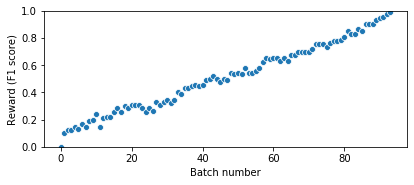

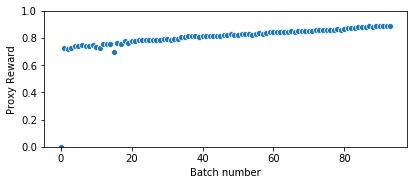

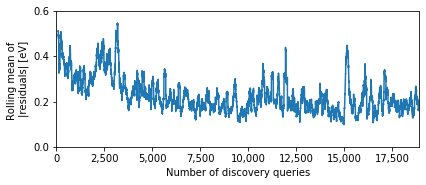

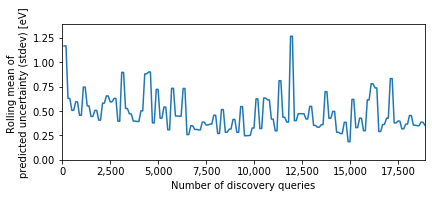

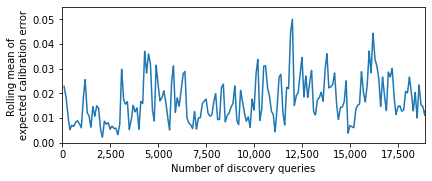

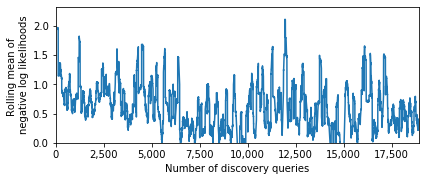

In [7]:
import warnings
import sys
from src.discoverers.adsorption.tpotheuristic import TpotHeuristic


# The GASpy fingerprinter will be yelling at us a lot about missing data.
# Good to know in production, but also good to ignore here.
with warnings.catch_warnings():
    warnings.filterwarnings(message='We do not have any energy data for %s on ' % adsorbate, action='ignore')

    # Initialize
    tpot_discoverer = TpotHeuristic(target_energy=target_energy,
                                    quantile_cutoff=quantile_cutoff,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False  # Set to `False` only for warm starts
                                   )

# Load
tpot_discoverer.load_last_run()

# Plot
tpot_figs = tpot_discoverer.plot_performance(window=100)

# Comparison
## Initialization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import pandas as pd


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
FIG_SIZE = (6.5, 2.5)


def plot_rolling_metric(ax, metric_values, metric_name, label=None,
                        window=200, smoother='mean', unit=''):
    '''
    Helper function to plot model performance metrics across time in
    hallucination.

    Args:
        ax              Matplotlib ax object to plot onto
        metric_values   A sequence of floats that will be plotted against
                        batch number in the hallucination.
        metric_name     A string indicating what you want the values to be
                        labeled as in the plots.
        label           A string indicating the label you want to use for
                        the data
        window          How many points to roll over during each iteration
        smoother        String indicating how you want to smooth the
                        residuals over the course of the hallucination.
                        Corresponds exactly to the methods of the
                        `pandas.DataFrame.rolling` class, e.g., 'mean',
                        'median', 'min', 'max', 'std', 'sum', etc.
        unit            [Optional] String indicating the units you want to
                        label the plot with
    '''
    # Format the data
    df = pd.DataFrame(metric_values, columns=[metric_name])
    rolling_residuals = getattr(df, metric_name).rolling(window=window)
    rolled_values = getattr(rolling_residuals, smoother)().values
    query_numbers = list(range(len(rolled_values)))

    # Create and format the figure
    _ = sns.lineplot(query_numbers, rolled_values, ax=ax, label=label)
    _ = ax.set_xlabel('Number of discovery queries')
    if unit:
        unit = ' [' + unit + ']'
    _ = ax.set_ylabel('Rolling %s of \n%s%s' % (smoother, metric_name, unit))
    _ = ax.set_xlim([query_numbers[0], query_numbers[-1]])
    _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])
    _ = fig.set_size_inches(*FIG_SIZE)
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    return fig

## F1 Score

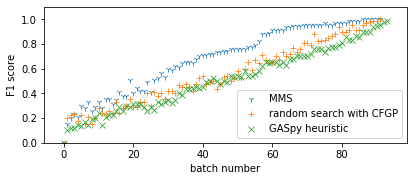

In [9]:
fig = plt.figure()

ax_mms = sns.scatterplot(list(range(len(mms_discoverer.reward_history))),
                         mms_discoverer.reward_history,
                         label='MMS', marker='1')
ax_rs = sns.scatterplot(list(range(len(rs_discoverer.reward_history))),
                        rs_discoverer.reward_history,
                        label='random search with CFGP', marker='+')
ax_tpot = sns.scatterplot(list(range(len(tpot_discoverer.reward_history))),
                          tpot_discoverer.reward_history,
                          label='GASpy heuristic', marker='x')

_ = ax_mms.set_xlabel('batch number')
_ = ax_mms.set_ylabel('F1 score')
_ = ax_mms.set_ylim(0., 1.1)
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax_mms.get_xaxis().set_major_formatter(FORMATTER)

## Residuals

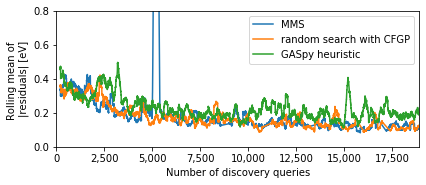

In [10]:
fig = plt.figure()
ax = fig.gca()

_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(mms_discoverer.residuals),
                        label='MMS',
                        metric_name='|residuals|',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(rs_discoverer.residuals),
                        label='random search with CFGP',
                        metric_name='|residuals|',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=np.abs(tpot_discoverer.residuals),
                        label='GASpy heuristic',
                        metric_name='|residuals|',
                        unit='eV')

_ = ax.set_ylim([0., 0.8])

## Sharpness

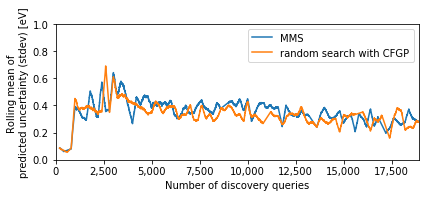

In [11]:
fig = plt.figure()
ax = fig.gca()

_ = plot_rolling_metric(ax=ax,
                        metric_values=mms_discoverer.uncertainties,
                        label='MMS',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
_ = plot_rolling_metric(ax=ax,
                        metric_values=rs_discoverer.uncertainties,
                        label='random search with CFGP',
                        metric_name='predicted uncertainty (stdev)',
                        unit='eV')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=tpot_discoverer.uncertainties,
#                        label='GASpy heuristic',
#                        metric_name='predicted uncertainty (stdev)',
#                        unit='eV')

_ = ax.set_ylim([0., 1.])

## Calibration

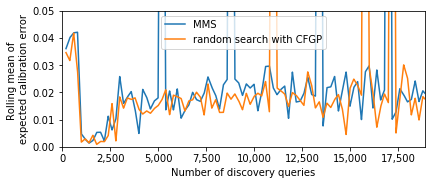

In [12]:
from tqdm.notebook import tqdm


fig = plt.figure()
ax = fig.gca()


def calculate_eces(discoverer, window=200):
    # Divide the data into chunks, which we need to calculate ECE
    chunked_residuals = discoverer.chunk_iterable(discoverer.residuals, window)
    chunked_uncertainties = discoverer.chunk_iterable(discoverer.uncertainties, window)

    # Calculate ECE
    loop = tqdm(zip(chunked_residuals, chunked_uncertainties),
                desc='calibration', unit='batch', total=len(chunked_residuals))
    for resids, stdevs in loop:
        ece = discoverer.calculate_expected_calibration_error(resids, stdevs)
        try:
            eces.extend([ece] * len(resids))
        # EAFP for initialization
        except NameError:
            eces = [ece] * len(resids)
    return eces


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(mms_discoverer),
                        label='MMS',
                        metric_name='expected calibration error')
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_eces(rs_discoverer),
                        label='random search with CFGP',
                        metric_name='expected calibration error')
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=calculate_eces(tpot_discoverer),
#                        label='GASpy heuristic',
#                        metric_name='expected calibration error')

_ = ax.set_ylim([0., 0.05])

## NLL

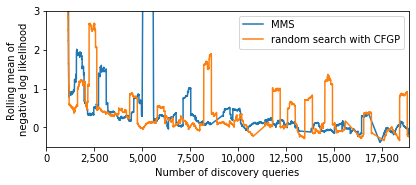

In [13]:
from scipy.stats import norm


fig = plt.figure()
ax = fig.gca()


def calculate_nlls(discoverer):
    nlls = [-norm.logpdf(resid, loc=0., scale=std)
            for resid, std in zip(discoverer.residuals, discoverer.uncertainties)]
    return nlls


_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(mms_discoverer),
                        label='MMS',
                        metric_name='negative log likelihood',
                        window=400)
_ = plot_rolling_metric(ax=ax,
                        metric_values=calculate_nlls(rs_discoverer),
                        label='random search with CFGP',
                        metric_name='negative log likelihood',
                        window=400)
#_ = plot_rolling_metric(ax=ax,
#                        metric_values=calculate_nlls(tpot_discoverer),
#                        label='GASpy heuristic',
#                        metric_name='negative log likelihood',
#                        window=400)

_ = ax.set_ylim([-0.5, 3.])

# Munging
## Initialization/loading

In [14]:
import os
import pickle
import random
from collections import defaultdict
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# For easier typing/referencing
disc = mms_discoverer

# Load one cache
with open('../MMS/mms_caches/000_discovery_cache.pkl', 'rb') as file_handle:
    cache = pickle.load(file_handle)
energies, stdevs, surfaces = cache['_predicted_energies']

# Calculate energies by surface using our framework
energies_by_surface = disc.calculate_low_coverage_binding_energies_by_surface((energies, stdevs, surfaces))
all_surfaces = {surf for surf in surfaces}
all_bulks = {surf[0] for surf in all_surfaces}

# Calculate values by surface using our framework
values_by_surface = disc.calculate_surface_values(energies_by_surface)

# Calculate values by bulk using our framework
bulk_values = disc.calculate_bulk_values(values_by_surface)

## Double-check shapes of distributions and calculations of values

In [41]:
# Pick a surface
surface = random.choice(list(all_surfaces))
mpid = surface[0]
print(surface)

('mp-641', (1, 0, -1), 0.03299526999999985, True)


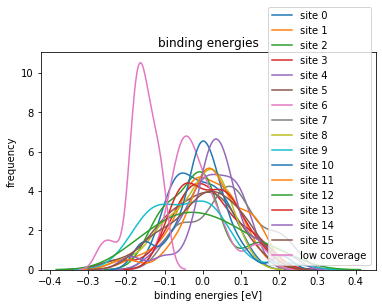

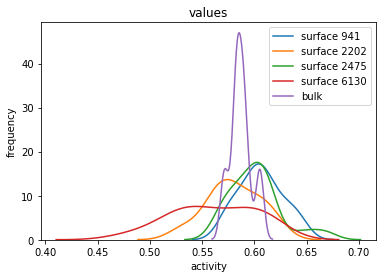

In [42]:
# Concatenate raw site information by surface
dists_by_surface = defaultdict(list)
for energy, stdev, surf in zip(energies, stdevs, surfaces):
    dists_by_surface[surf].append((energy, stdev))


# Initialize site-level plot
fig = plt.figure()

# Plot each site distribution
for i, (energy, stdev) in enumerate(dists_by_surface[surface]):
    samples = norm.rvs(loc=energy, scale=stdev, size=20)
    _ = sns.distplot(samples, kde=True, hist=False, label='site %i' % i)

# Plot the low-coverage distribution that we predicted
ax = sns.distplot(energies_by_surface[surface], kde=True, hist=False, label='low coverage')

# Formatting
_ = ax.legend()
_ = ax.set_title('binding energies')
_ = ax.set_xlabel('binding energies [eV]')
_ = ax.set_ylabel('frequency')


# Initialize value plot
fig = plt.figure()
ax = fig.gca()

# Plot surface values
for i, (surf, values) in enumerate(values_by_surface.items()):
    bulk = surf[0]
    if bulk == mpid:
        _ = sns.distplot(values, kde=True, hist=False, label='surface %i' % i, ax=ax)

        # Plot the bulk value
_ = sns.distplot(bulk_values[mpid], kde=True, hist=False, label='bulk', ax=ax)

# Format
_ = ax.legend()
_ = ax.set_title('values')
_ = ax.set_xlabel('activity')
_ = ax.set_ylabel('frequency')